## Import Libraries

In [122]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [123]:
df = pd.read_csv("./DF_Classification.csv")

In [124]:
df.shape

(3386, 19)

In [125]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,8,Manchester United,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758,47,13,0,2000000,2000000
1,10,Manchester United,Defender Left-Back,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132,182,15,3,22000000,22000000


In [126]:
df.drop(columns='Unnamed: 0' , inplace = True)
# df.drop(columns='name' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [127]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [128]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [129]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [130]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [131]:
for i in categorical_col:
    print(df[i].value_counts())

team
Southampton FC       21
AFC Bournemouth      20
AJ Auxerre           19
Orlando Pirates      19
Huddersfield Town    19
                     ..
Daegu FC              1
FC Seoul              1
Austin FC             1
Real Madrid           1
Kashima Antlers       1
Name: count, Length: 323, dtype: int64
position
Defender Centre-Back          783
midfield-CentralMidfield      466
Defender Right-Back           370
midfield-DefensiveMidfield    361
Defender Left-Back            345
Attack Centre-Forward         313
midfield-AttackingMidfield    235
Attack-RightWinger            227
Attack-LeftWinger             199
midfield-RightMidfield         35
midfield-LeftMidfield          30
Attack-SecondStriker           16
Goalkeeper                      3
Attack                          1
Defender                        1
midfield                        1
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [132]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758,47,13,0,2000000,2000000
1,Manchester United,Defender Left-Back,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132,182,15,3,22000000,22000000


In [133]:
categorical_col = ['team']

In [134]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [135]:
df.shape

(3386, 340)

In [136]:
encoder = LabelEncoder()
df['position'] = encoder.fit_transform(df['position'])  

#### 3. Feature selection

In [137]:
# sns.heatmap(df.corr(), annot=True);

In [138]:
correlation = df.corr()
correlation['position'].sort_values(ascending=False)

position                1.000000
yellow cards            0.191554
minutes played          0.068293
team_Spartak Moscow     0.045466
team_Bologna FC 1909    0.040503
                          ...   
team_Cádiz CF          -0.038223
age                    -0.047603
assists                -0.103474
height                 -0.134309
goals                  -0.414769
Name: position, Length: 340, dtype: float64

In [139]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['position']) > threshold]['position'].index
selected_features

Index(['position', 'goals'], dtype='object')

#### 4. Prepare train and test data

In [140]:
# Prepare data
X = df.drop(['position'], axis=1)
y = df['position']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [141]:
X.shape

(3386, 339)

## Buliding the Model

In [142]:
model = SVC()

In [143]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [144]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [145]:
grid_search.best_params_

{'C': 2, 'gamma': 2, 'kernel': 'rbf'}

In [146]:
model = grid_search.best_estimator_

## Test the Model

In [147]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [148]:
# our benchmark model
base_model = round(df['position'].value_counts()[1]/df.shape[0]*100, 2)
base_model

9.24

1. Accuracy

In [149]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy*100

24.778761061946902

In [150]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy*100

100.0

2. Precision

In [151]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.02


In [152]:
y_pred_train = model.predict(X_train_scaled)
precision = precision_score(y_train, y_pred_train,average='macro')
precision

1.0

3. Recall

In [153]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.08


In [154]:
y_pred_train = model.predict(X_train_scaled)
recall = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 1.00


4. F1 Score

In [155]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.03


In [156]:
y_pred_train = model.predict(X_train_scaled)
f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 1.00


#### Predictions vs. Real Values

In [157]:
predictions = model.predict(X_test_scaled)

In [158]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

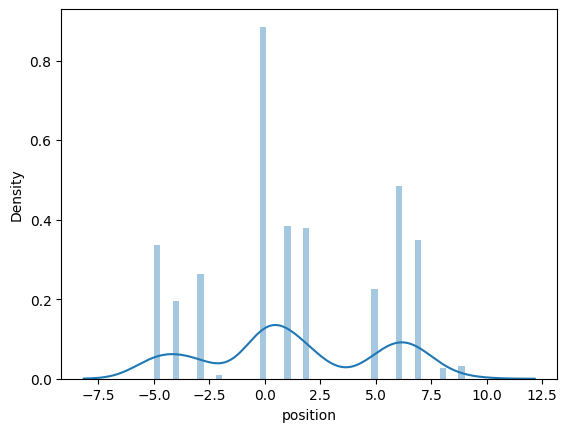

In [159]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [160]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[  0,   0,   0,   0,  64,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  37,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 168,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  73,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  72,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  43,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  92,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  66,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   6,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)